# このモデルを選択した理由

> 受講した講座を通じて、また自習を続けた結果として、プログラム構造としてのディープラーニングの理解は深まっているという実感があるのですが、数学的な理解という面で、まだまだ実力が足りていないと考えています。そのため、このモデルでは次の点を考慮しています。
1.   順伝播や逆伝播で行う数学的な処理を、出来るだけ率直にコード化すること
2.   数学的に必要な計算ステップ以外の要素は、出来るだけコード化しないこと

> やっている事が最低限なので、逆に言うとこれに何かを付け足すことも容易なのだと思います。ですので、再提出のテーマとしては、1回目の正解率87.5%を超えることを目標として、次のような改良を行い、それに伴って学習にかかる時間がどう変化するのか計測し、結果の考察を行おうと思います。（末尾に記述）
1.   学習を10回から30回に増やしてみた場合の正解率と学習時間の変化
2.   中間層を2階層に増やしてみた場合の正解率と学習時間の変化










In [3]:
#Google Drive1のマウント
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#パスの確認
!ls '/content/drive/My Drive/Colab Notebooks/E資格対応講座1906/submission/mldata'
!pwd

from sklearn.datasets.base import get_data_home 
print (get_data_home()) 

mldata	mnist-original.mat
/content
/root/scikit_learn_data


In [0]:
#必要ライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
#MNISTデータの読み込み
from sklearn import datasets
#Google Colaboratoryでは第2引数無しにすれば読み込みできるという情報があったが、
#頻繁にタイムアウトするのでGoogle Driveのマウントしたところから読むことにした。
mnist = datasets.fetch_mldata('MNIST original', data_home='/content/drive/My Drive/Colab Notebooks/E資格対応講座1906/submission/')
x_org, y_org = mnist.data, mnist.target

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
#入力データの加工と学習データ、テストデータへの分割

#x
#データを正規化して先頭にダミー変数を追加
x_normalize = x_org / 255.0
x_processed = np.insert(x_normalize, 0, 1, axis = 1)

#y
#One Hotベクトルのデータとなるように加工
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
y_ohv = ohe.fit_transform(np.c_[y_org])

#分割
#yは、y_orgからy_train, y_testと、y_ohvからy_train_ohv, y_test_ohvにそれぞれ分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, y_train_ohv, y_test_ohv = \
train_test_split(x_processed, y_org, y_ohv, train_size = 60000, test_size = 10000, shuffle = False)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
#softmax関数
def softmax(x):
  x = x.T
  x_max = x.max(axis = 0)
  x = x - x_max
  w = np.exp(x)
  return (w / w.sum(axis = 0)).T

#クロスエントロピー関数
def cross_entropy(yt, yp):
  return -np.mean(np.sum(yt * np.log(yp), axis = 1))

#ReLU関数
def ReLU(x):
  return np.maximum(0, x)

#step関数
def step(x):
  return 1.0 * (x > 0)

#評価関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_ohv, V, W):
  b1_test = np.insert(ReLU(np.dot(x_test, V)), 0, 1, axis = 1)
  yp_test_ohv = softmax(np.dot(b1_test, W))
  yp_test = np.argmax(yp_test_ohv, axis = 1)
  loss = cross_entropy(y_test_ohv, yp_test_ohv)
  score = accuracy_score(y_test, yp_test)
  return score, loss

In [0]:
#中間層のノード数
H = 100
H1 = H + 1 #ダミー変数の分1増やす

#訓練データ数
M = x_train.shape[0]

#学習データの次元数
D = x_train.shape[1]

#分類クラス数
N = y_train_ohv.shape[1]

#ハイパーパラメータ
alpha = 0.01

#ミニバッチ制御
batch_size = 600

In [0]:
#重み、バイアス行列の初期値
V = np.random.randn(D, H) * 0.085
W = np.random.randn(H1, N) / np.sqrt(H1 / 2) #He normal法による初期化

#エポック数の設定
epoch = 10

In [14]:
start = time.time()
#学習（エポック数10、中間層1層）
x_train_rowcount, x_train_colcount = x_train.shape
for ep in range(epoch):
  perm = np.random.permutation(x_train_rowcount)
  
  for idx in range(0, x_train.size, batch_size):
    x = x_train[perm[idx:idx + batch_size]]
    yt = y_train_ohv[perm[idx:idx + batch_size]]
    
    #順伝播(予測値の計算)
    a = np.dot(x, V)
    b = ReLU(a)
    b1 = np.insert(b, 0, 1, axis = 1)
    u = np.dot(b1, W)
    yp = softmax(u)
    
    #誤差計算
    yd = yp - yt
    bd = step(a) * (np.dot(yd, W[1:].T))
  
    #勾配計算
    W = W - alpha * (np.dot(b1.T, yd)) / batch_size
    V = V - alpha * (np.dot(x.T, bd)) / batch_size
  
  score, loss = evaluate(x_test, y_test, y_test_ohv, V, W)
  print('epoch = %d loss = %f score = %f' % (ep, loss, score))

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

epoch = 0 loss = 1.589639 score = 0.578300
epoch = 1 loss = 1.113139 score = 0.751200
epoch = 2 loss = 0.857076 score = 0.806100
epoch = 3 loss = 0.714719 score = 0.833300
epoch = 4 loss = 0.626583 score = 0.849900
epoch = 5 loss = 0.567813 score = 0.858100
epoch = 6 loss = 0.525850 score = 0.865500
epoch = 7 loss = 0.493484 score = 0.871900
epoch = 8 loss = 0.468462 score = 0.876900
epoch = 9 loss = 0.448386 score = 0.879900
elapsed_time:311.7118375301361[sec]


In [0]:
#重み、バイアス行列の初期値
V = np.random.randn(D, H) * 0.085
W = np.random.randn(H1, N) / np.sqrt(H1 / 2) #He normal法による初期化

#エポック数の設定
epoch = 30

In [16]:
start = time.time()
#学習（エポック数30、中間層1層）
x_train_rowcount, x_train_colcount = x_train.shape
for ep in range(epoch):
  perm = np.random.permutation(x_train_rowcount)
  
  for idx in range(0, x_train.size, batch_size):
    x = x_train[perm[idx:idx + batch_size]]
    yt = y_train_ohv[perm[idx:idx + batch_size]]
    
    #順伝播(予測値の計算)
    a = np.dot(x, V)
    b = ReLU(a)
    b1 = np.insert(b, 0, 1, axis = 1)
    u = np.dot(b1, W)
    yp = softmax(u)
    
    #誤差計算
    yd = yp - yt
    bd = step(a) * (np.dot(yd, W[1:].T))
  
    #勾配計算
    W = W - alpha * (np.dot(b1.T, yd)) / batch_size
    V = V - alpha * (np.dot(x.T, bd)) / batch_size
  
  score, loss = evaluate(x_test, y_test, y_test_ohv, V, W)
  print('epoch = %d loss = %f score = %f' % (ep, loss, score))

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

epoch = 0 loss = 1.647564 score = 0.552000
epoch = 1 loss = 1.158994 score = 0.704500
epoch = 2 loss = 0.897845 score = 0.771700
epoch = 3 loss = 0.752396 score = 0.807000
epoch = 4 loss = 0.661463 score = 0.829600
epoch = 5 loss = 0.599770 score = 0.842700
epoch = 6 loss = 0.554921 score = 0.852100
epoch = 7 loss = 0.520632 score = 0.858600
epoch = 8 loss = 0.493592 score = 0.865000
epoch = 9 loss = 0.471653 score = 0.872800
epoch = 10 loss = 0.453246 score = 0.876900
epoch = 11 loss = 0.437947 score = 0.880200
epoch = 12 loss = 0.424454 score = 0.883100
epoch = 13 loss = 0.412788 score = 0.886000
epoch = 14 loss = 0.402638 score = 0.888100
epoch = 15 loss = 0.393401 score = 0.890300
epoch = 16 loss = 0.385186 score = 0.893400
epoch = 17 loss = 0.377703 score = 0.895300
epoch = 18 loss = 0.370829 score = 0.897100
epoch = 19 loss = 0.364706 score = 0.899500
epoch = 20 loss = 0.358960 score = 0.900400
epoch = 21 loss = 0.354007 score = 0.901600
epoch = 22 loss = 0.349043 score = 0.90290

In [17]:
import matplotlib.pyplot as plt
'''
#サンプル数
N = 20

perm = np.random.permutation(y_test.shape[0])
x_selected = x_test[perm]
y_selected = y_test[perm]


# 予測値の計算
b1_test = np.insert(ReLU(np.dot(x_selected, V)), 0, 1, axis = 1)
yp_test_ohv = softmax(np.dot(b1_test, W))
yp_test = np.argmax(yp_test_ohv, axis = 1)

# グラフ表示
print('正解値:予測値')
plt.figure(figsize = (10, 3))
for i in range(N):
    ax = plt.subplot(2, N / 2, i + 1)
    plt.imshow(x_selected[i, 1:].reshape(28, 28))
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
'''

"\n#サンプル数\nN = 20\n\nperm = np.random.permutation(y_test.shape[0])\nx_selected = x_test[perm]\ny_selected = y_test[perm]\n\n\n# 予測値の計算\nb1_test = np.insert(ReLU(np.dot(x_selected, V)), 0, 1, axis = 1)\nyp_test_ohv = softmax(np.dot(b1_test, W))\nyp_test = np.argmax(yp_test_ohv, axis = 1)\n\n# グラフ表示\nprint('正解値:予測値')\nplt.figure(figsize = (10, 3))\nfor i in range(N):\n    ax = plt.subplot(2, N / 2, i + 1)\n    plt.imshow(x_selected[i, 1:].reshape(28, 28))\n    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]))\n    ax.get_xaxis().set_visible(False)\n    ax.get_yaxis().set_visible(False)\nplt.show()\n"

In [0]:
#評価関数
def evaluate_2layer(x_test, y_test, y_test_ohv, U, V, W):
  b1_test = np.insert(ReLU(np.dot(x_test, U)), 0, 1, axis = 1)
  d1_test = np.insert(ReLU(np.dot(b1_test, V)), 0, 1, axis = 1)
  yp_test_ohv = softmax(np.dot(d1_test, W))
  yp_test = np.argmax(yp_test_ohv, axis = 1)
  loss = cross_entropy(y_test_ohv, yp_test_ohv)
  score = accuracy_score(y_test, yp_test)
  return score, loss

In [0]:
#中間層のノード数
H = 100
H1 = H + 1 #ダミー変数の分1増やす

#訓練データ数
M = x_train.shape[0]

#学習データの次元数
D = x_train.shape[1]

#分類クラス数
N = y_train_ohv.shape[1]

#ハイパーパラメータ
alpha = 0.01

#ミニバッチ制御
batch_size = 600

In [0]:
#重み、バイアス行列の初期値
U = np.random.randn(D, H) * 0.085
V = np.random.randn(H1, H) / np.sqrt(H1 / 2) #He normal法による初期化
W = np.random.randn(H1, N) / np.sqrt(H1 / 2) #He normal法による初期化

#エポック数の設定
epoch = 10

In [21]:
start = time.time()
#学習（エポック数10、中間層2層）
x_train_rowcount, x_train_colcount = x_train.shape
for ep in range(epoch):
  perm = np.random.permutation(x_train_rowcount)
  
  for idx in range(0, x_train.size, batch_size):
    x = x_train[perm[idx:idx + batch_size]]
    yt = y_train_ohv[perm[idx:idx + batch_size]]
    
    #順伝播(予測値の計算)
    a = np.dot(x, U)
    b = ReLU(a)
    b1 = np.insert(b, 0, 1, axis = 1)
    c = np.dot(b1, V)
    d = ReLU(c)
    d1 = np.insert(d, 0, 1, axis = 1)
    u = np.dot(d1, W)
    yp = softmax(u)
    
    #誤差計算
    yd = yp - yt
    dd = step(c) * (np.dot(yd, W[1:].T))
    bd = step(a) * (np.dot(dd, V[1:].T))
    
    #勾配計算
    W = W - alpha * (np.dot(d1.T, yd)) / batch_size
    V = V - alpha * (np.dot(b1.T, dd)) / batch_size
    U = U - alpha * (np.dot(x.T, bd)) / batch_size
  
  score, loss = evaluate_2layer(x_test, y_test, y_test_ohv, U, V, W)
  print('epoch = %d loss = %f score = %f' % (ep, loss, score))

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

epoch = 0 loss = 1.509316 score = 0.621300
epoch = 1 loss = 0.976208 score = 0.762300
epoch = 2 loss = 0.726195 score = 0.814500
epoch = 3 loss = 0.600234 score = 0.840900
epoch = 4 loss = 0.526630 score = 0.858200
epoch = 5 loss = 0.478518 score = 0.868300
epoch = 6 loss = 0.444348 score = 0.875400
epoch = 7 loss = 0.419614 score = 0.880600
epoch = 8 loss = 0.399283 score = 0.885800
epoch = 9 loss = 0.382905 score = 0.889900
elapsed_time:351.01003909111023[sec]


正解値:予測値


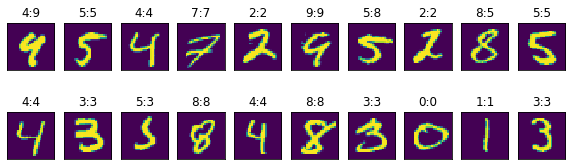

In [23]:
#サンプル数
N = 20

perm = np.random.permutation(y_test.shape[0])
x_selected = x_test[perm]
y_selected = y_test[perm]


# 予測値の計算
b1_test = np.insert(ReLU(np.dot(x_selected, U)), 0, 1, axis = 1)
d1_test = np.insert(ReLU(np.dot(b1_test, V)), 0, 1, axis = 1)
yp_test_ohv = softmax(np.dot(d1_test, W))
yp_test = np.argmax(yp_test_ohv, axis = 1)

# グラフ表示（中間層が2層の場合用）
print('正解値:予測値')
plt.figure(figsize = (10, 3))
for i in range(N):
    ax = plt.subplot(2, N / 2, i + 1)
    plt.imshow(x_selected[i, 1:].reshape(28, 28))
    ax.set_title('%d:%d' % (y_selected[i], yp_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#学習の回数を増やした場合と中間層を増やした場合を比較した結果の考察


> 学習を10回から30回に増やした結果、正解率は87.9%から90.8%に向上しました。一方で学習時間は311秒から954秒へと、約3倍に増加しました。学習を3倍に増加した結果、学習時間もそれに比例して3倍かかることとなりましたが、正解率も約3％向上したので、学習の回数は最低30回くらいは必要そうだ、という事がわかりました。

> 次に、中間層を2層に増やした結果、学習を10回としても正解率は88.9%と、1層のモデルと比較して向上しています。中間層を2層に増やしたモデルは、1層のものと比較して損失関数の数値の下がり方が良く、この差が正解率の向上に表れているのだと考えています。また、学習時間は約1.12倍に増加していますが、GPUの利用や並列処理が可能なフレームワークを利用すれば、この差は小さくできるのではないかと考えています。

> このモデルは、MNISTのデータを単にビットの羅列として学習しているので、CNNなど画像として処理する方式を導入すれば、正解率を向上させる事ができるのは明らかですが、単純に学習の回数や階層を深くする事でも、正解率は向上する事がわかりました。今回は行っていませんが、中間層のノード数を変えて、ネットワークの横方向への拡張も可能なので、チューニングの余地が色々ある事を実感できました。

> 余談ですが、再提出に当たって追加の記述を行ってみて、学習の回数や階層が何層あるのかによって、正解率や学習時間がどの程度変化するのかについて、簡単に施行できる構造のプログラムになっていた事が改めて分かりました。自身が理解するという意味では、この演習の方向性は正しかったと考えています。


